In [91]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import modules_TFM as mod
import tables as tb

from scipy.optimize import curve_fit

### Data reading

Reading data from run 14913, using the same procedure as in NEXT-doc-1734-v1. We start by reading data from the kdst. We just read from the first ldc but results with other ldc should be similar

In [92]:
intput_file = '/Volumes/EXTERNAL_US/NEXT/Data/14893/14893_ldc7_merged.kdst'

with tb.open_file(intput_file, mode='r') as h5file:
    events = h5file.root.DST.Events
   
    column_names = events.block0_items.read().astype(str)

    data = events.block0_values.read()

    df = pd.DataFrame(data, columns=column_names)

data = df

data

,time,S1w,S1h,S1e,S1t,S2w,S2h,S2e,S2q,S2t,qmax,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,1.741242e+09,225.0,1.676715,7.197778,1396200.0,15.250,1263.182739,8211.812500,837.904785,1604491.750,150.781723,208.291763,208.291763,2.627837,234.298929,-42.900654,238.194153,-0.181096,12.394457,12.027787
1,1.741242e+09,200.0,1.159960,6.917334,1499600.0,11.650,1099.464600,5553.045410,637.743896,1601480.875,141.455154,101.880882,101.880882,1.931194,35.575621,-468.042060,469.392155,-1.494933,11.363613,10.970909
2,1.741242e+09,150.0,1.187743,5.411891,935275.0,26.000,605.666382,7192.554688,586.469055,1605495.250,76.726196,670.220276,670.220276,4.923906,397.663570,115.881053,414.203734,0.283553,13.482987,14.881957
3,1.741242e+09,250.0,1.419458,7.735036,679750.0,30.025,549.894897,7577.809570,421.544800,1604485.125,60.838726,924.735168,924.735168,5.515615,376.601149,120.689113,395.467176,0.310129,13.872063,15.419375
4,1.741242e+09,275.0,1.330621,9.791548,174825.0,25.300,666.986084,8002.841309,589.348877,1608456.875,91.241608,1433.631958,1433.631958,4.646213,-303.807049,-165.033292,345.737921,-2.643972,12.907360,13.956971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532714,1.741264e+09,125.0,4.419601,18.210859,102225.0,40.700,2209.153076,33826.398438,2607.708740,1879486.375,238.559143,1777.261475,1777.261475,6.346785,-16.974324,-201.208506,201.923229,-1.654959,18.861198,17.862909
532715,1.741264e+09,275.0,2.454063,22.157822,103750.0,16.200,1099.830444,7376.771484,685.823792,1601489.000,134.006989,1497.739014,1497.739014,2.762944,-334.194881,-268.715284,428.828779,-2.464376,12.885005,12.882584
532716,1.741264e+09,275.0,2.454063,22.157822,103750.0,40.700,2209.153076,33826.398438,2607.708740,1879486.375,238.559143,1775.736450,1775.736450,6.346785,-16.974324,-201.208506,201.923229,-1.654959,18.861198,17.862909
532717,1.741264e+09,125.0,1.219534,4.486968,1385200.0,16.200,1099.830444,7376.771484,685.823792,1601489.000,134.006989,216.289017,216.289017,2.762944,-334.194881,-268.715284,428.828779,-2.464376,12.885005,12.882584


We impose the first initial cuts. Opening the dataframe I see no information about the S1 peaks so I will not ask our data to have just one S1, this is not an ideal situation but it is what I got. We also asked our data to be within a window of $\text{DT}_{rms}$ among 0 and 20 $\mu\text{s}$ so we avoid dealing with outliers, we are not biasing our sample too much as we will impose some later cuts to ask them to be within a more restrictive window which matchs better with our MC, where most of our events are. We are in a situation with almost no cuts on the DT due to the no existance of alphas in the run

In [93]:
real_data=data[(data.DT>0) & (data.S1e>5) & (data.Zrms < 20) & (data.DT < 1350)] 

Here we define our second window. As we can see in the plot below, the cut we get is quite clean and we can in fact take the window of events inside the red lines. 

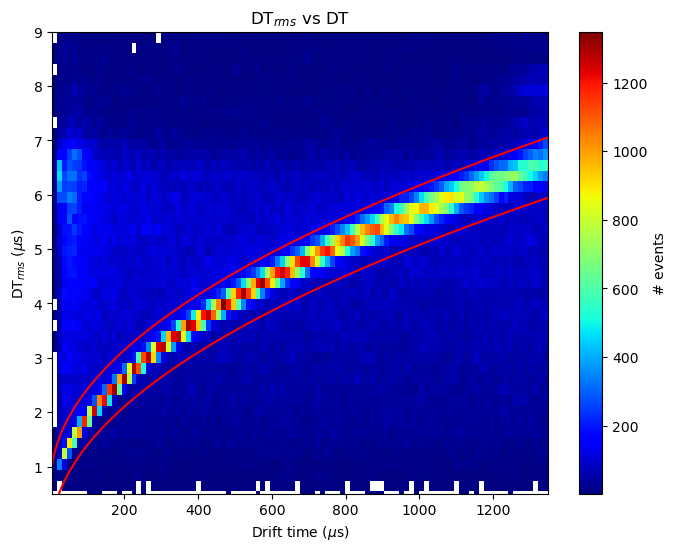

In [94]:
f= lambda x,a,b: a+b*x**0.5
f1 = lambda x: f(x, 0.7, 0.173)
f2 = lambda x: f(x,-0.3, 0.17)

x=np.linspace(0, max(real_data.DT),len(real_data.Zrms))

plt.figure(figsize=(8,6));

plt.plot(x,f1(x), color='red');
plt.plot(x,f2(x), color='red'); 
plt.title(r'DT$_{rms}$ vs DT');

plt.xlabel(r'Drift time ($\mu$s)');
plt.ylabel(r'DT$_{rms}$ ($\mu$s)');

plt.hist2d(real_data.DT, real_data.Zrms, bins = (100,100) , cmap = 'jet', cmin = 1);
plt.ylim(.5,9);
plt.colorbar(label = '# events');

Here is where we actually take the events within the band

In [95]:
DT_raw=real_data.DT
Zrms_raw=real_data.Zrms
mask=(Zrms_raw<f1(DT_raw))&(Zrms_raw>f2(DT_raw))
inverse_mask=~mask

dst_in=real_data[mask]

Now we plot our data after these selection cuts and check that our cuts worked properly, getting a cleaner sample of events to study.

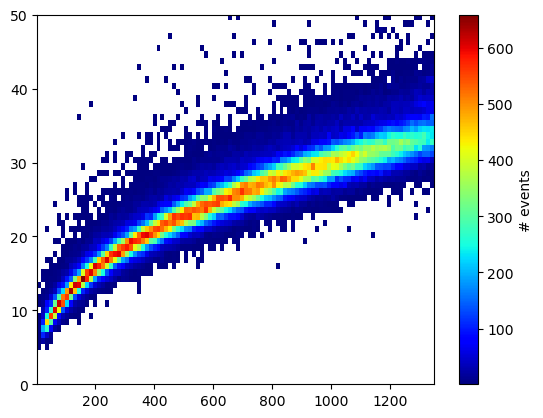

In [96]:
plt.hist2d(dst_in.DT, dst_in.S2w, bins = (100,100) , cmap = 'jet', cmin = 1);
plt.colorbar(label = '# events');
plt.ylim(0,50);

### Calculating the diffusion during the run

Assuming a temperature, $T = 25^oC$, a pressure, $P = 4 \text{bar}$ and a compresibility factor of $Z = 0.971$ we can calculate the diffusion coefficient. In fact these are standard conditions that will be considered generally in our studies of diffusion if we are not being told no to do so.

In [97]:
print('La presion reducida es:',4/58.42)
print(r'La temperatura reducida es, suponiendo T=25C:', (273.15+25)/289.733)

print('El factor de compresibilidad es entonces:', 0.971)


P=4
T=25
Z=0.971

La presion reducida es: 0.06846970215679561
La temperatura reducida es, suponiendo T=25C: 1.029050884780125
El factor de compresibilidad es entonces: 0.971


Here we define the formulas for the diffusion coefficients in standard units, first using the formula once we know the diffusion coefficients from the slope of my fit and then we will convert our results to the same units that Magboltz uses so we can actually compare the results we get.

In [98]:
def diffusion_coef(T,Z,vd,P,DL):
    T0=293.15
    Z0=0.961
    dif=np.sqrt((2*T0*Z0*P*DL)/(T*Z*vd))
    return dif

def conversion_unidades(coefficient):
    '''
        Returns the diffusion coefficient in um/sqrt(cm)
    '''
    return coefficient * 10**3 * 10**(1/2)

We calculate the profile of the data inside our window to get the points to fit to the formula for the diffusion

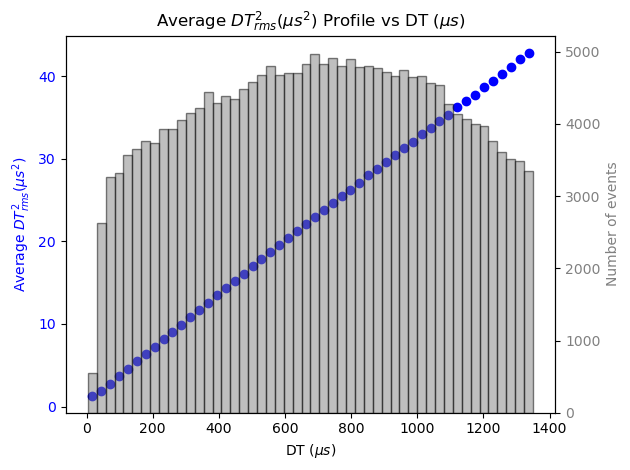

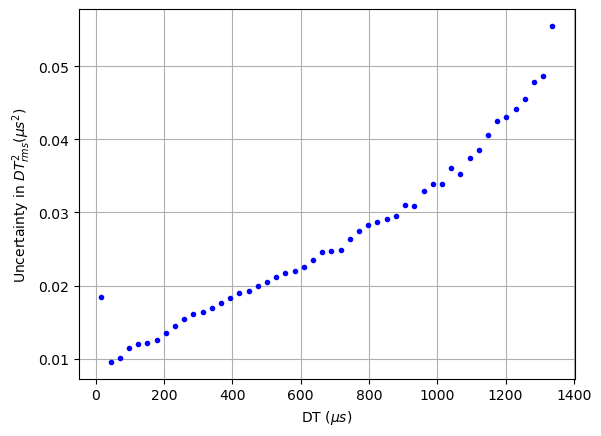

In [ ]:
DT_prof, Z_rms_mean_sq, Z_rms_mean_sq_rms = mod.profiles(dst_in['DT'], dst_in['Zrms']**2, threshold=0, x_label
                                                         =r'DT ($\mu s$)', y_label=r'$DT_{r ms}^2 (\mu s ^2)$',plot=True, normalize=True);

We clearly see a linear trend as we can expect from previous studies so we can just plot the points we got from the profile to fit them to a straight line. 

In [100]:
drift_velocity=0.865 # mm/ mu s !!!!!
profile_data_L=mod.Data1d(DT_prof, Z_rms_mean_sq, Z_rms_mean_sq_rms)

Using $v_d = 0.865 \frac{mm}{\mu s}$ (checked the value with Gonzalo)

In [101]:
def recta(x, a, b):
    return a*x+b

profile_data_L.fit(recta, p0=[0,0]);

We see our fit in the plot below and we see the perfect agreement with our that, as well as the low errorbars, that are so small that we really cannot see them in the plot

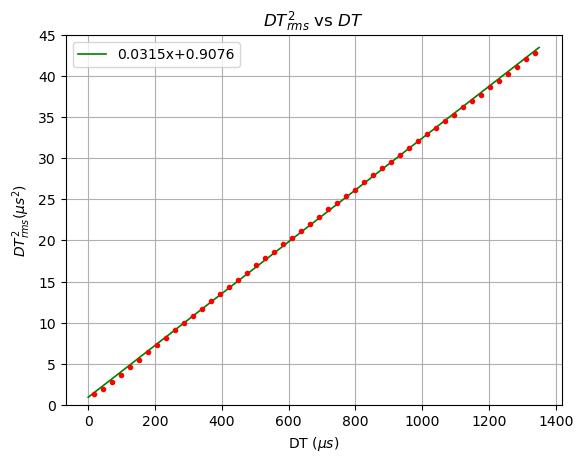

In [102]:
profile_data_L.plot()
plt.plot(np.linspace(0,1350,1000), recta(np.linspace(0,1350,1000), profile_data_L.fit(recta, p0=[0,0])[0][0],
                                        profile_data_L.fit(recta, p0=[0,0])[0][1]), linewidth=1.2, color='green',
                                        label=f'{np.round(profile_data_L.fit(recta, p0=[0,0])[0][0],4)}x+{np.round(profile_data_L.fit(recta, p0=[0,0])[0][1],4)}')
plt.xlabel(r'DT ($\mu s)$')
plt.ylabel(r'$DT_{rms}^2 (\mu s^2)$')
plt.ylim(0,45)
plt.title(r'$DT_{rms}^2$ vs $DT$ ')
plt.legend(loc='upper left')
plt.grid(True)

In the following cell we write the slope got from the fit and the uncertainty

In [103]:
slope_L=profile_data_L.fit(recta,p0=(0,0))[0][0]
incert_slope_L=np.sqrt(profile_data_L.fit(recta,p0=(0,0))[1][0,0])

print(slope_L)
print(incert_slope_L)

0.03154622071011446
7.257393696417515e-05


Calculamos ahora tanto el coeficiente de difusion como el valor de la incertidumbre.

In [104]:
slope = slope_L

def incert_Dl(incer_slope, incert_vd, vd, slope):
    a = (vd*slope*incert_vd)**2
    b = (incer_slope/2*vd**2)**2
    return np.sqrt(a+b)

def incert_Dlstar(incert_Dl, incert_vd, vd, DL):
    T0  = 293.15
    Z0  = 0.961
    cte = np.sqrt((2*T0*Z0*P)/(T*Z))

    a = (1/4/vd/DL*cte)*incert_Dl**2
    b = (1/4/vd**3/DL*cte)*incert_vd**2

    return np.sqrt(a+b)

DL=slope*drift_velocity**2/2
DL=conversion_unidades(diffusion_coef(293.15, 0.971, drift_velocity, 4, DL))
iDL = incert_Dl(incert_slope_L, 0.00016, drift_velocity, slope)
iDLstar = incert_Dlstar(iDL, 0.00016, drift_velocity, slope*drift_velocity**2/2)
print(f'{DL} +- {conversion_unidades(iDLstar)}')

print()
print(f'A campo reducido {114.45/3.96}')


1039.354730475017 +- 9.0839414267688

A campo reducido 28.901515151515152


### COMPARACION ENTRE LOS LDC

Puedo probar ahora calcular el promedio de las difusiones obtenidas entre los diferentes LDC's y ver si los valores que obtengo varían notablemente. La respuesta es que no y podemos calcular la media de la difusion en este estudio y para este run de Kripton usando este metodo 

In [107]:
difusion_stored = [1039.560414225545, 1039.7663266667075, 1039.4767067214952, 1038.6655134253128, 1039.6582094681014, 1039.4388495613032, 1039.354730475017]

print(f'La difusión promedio en los 7 ldcs es {np.mean(difusion_stored)} +- {np.std(difusion_stored)}')

La difusión promedio en los 7 ldcs es 1039.4172500776403 +- 0.33240040215918737


Nota: Esta incertidumbre que aparece es solo la desviacion estandar de la media asumiendo que los datos NO tuviesen una incertidumbre asociada

### Difusión Transversal

### AQUI FALLAN COSAS HAY QUE ECHARLE UN OJO IMPORTANTE.

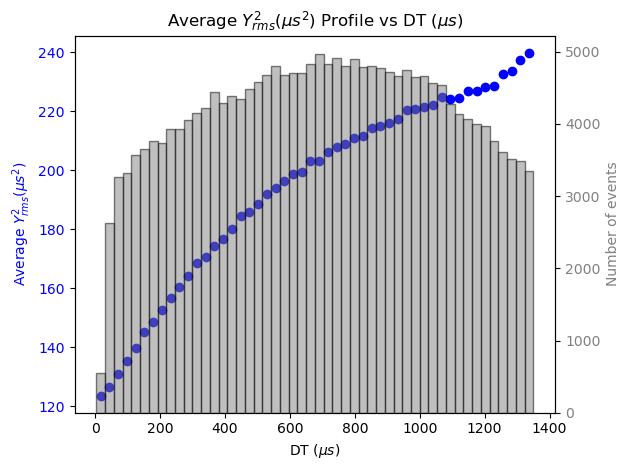

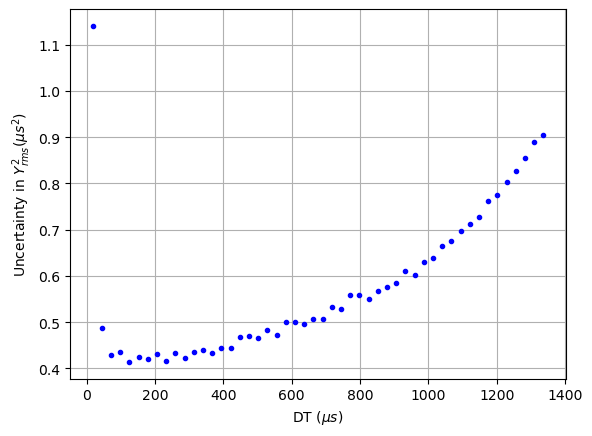

In [106]:
DT_prof, Y_rms_mean_sq, Y_rms_mean_sq_rms = mod.profiles(dst_in['DT'], dst_in['Yrms']**2, threshold=0, x_label
                                                         =r'DT ($\mu s$)', y_label=r'$Y_{r ms}^2 (\mu s ^2)$',plot=True, normalize=True);